In [ ]:
import torch
import numpy as np
import os
import PIL

In [ ]:
import torchvision
from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [ ]:
import pickle
import random
from tqdm.notebook import  tqdm
from PIL import Image
from pathlib import Path
from collections import namedtuple

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
from matplotlib import colors, pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#Подготовка данных

In [ ]:

DATA_MODES = ['train', 'val', 'test']


class Video_dataset(Dataset):
    def __init__(self, data, size, mode):
      super().__init__()
      self.videos = sorted(list(data.iterdir()))
      self.size = size
      self.index = []
      for i in range(len(self.videos)):
          file_in = self.videos[i]
          files = list(file_in.iterdir())
          for j in range(len(files)):

              self.index.append([i,j])



      self.mode = mode
      self.len_ = len(self.index)
      self.transform =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

      if self.mode not in DATA_MODES:
          print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
          raise NameError

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def suffle(self):
        random.shuffle(self.index)



    def prepare(self, img):

        img = self._prepare_sample(img)
        img = (img / 255).astype('float32')
        img = self.transform(img)
        return img

    def _prepare_sample(self, image):

        image = image.resize(self.size)
        return np.array(image)

    def get_input(self, index):

       video = self.videos[index[0]]
       sample = list(video.iterdir())[1]
       data = list(sample.iterdir())
       return data[0], data[1]

    def get_target(self, index):

       video = self.videos[index[0]]

       sample = list(video.iterdir())[index[1]]

       data = list(sample.iterdir())
       return data[0], data[1], data[2]

    def all(self):
       plt.figure()
       f, axarr = plt.subplots(6,1)
       i=0
       for elem in self.index:
            link_img1, link_img2, link_img3 =  self.get_target(elem)

            img1 = self.load_sample(link_img1)
            img1 = self.prepare(img1)
            img1 = img1.data.cpu()
            inp = img1.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            axarr[i].imshow(inp)
            i+=1
       plt.show()



    def __getitem__(self, index):

        if self.mode == 'test':
            link_img1, link_img2 =  self.get_input(self.index[index])
            img1 = self.load_sample(link_img1)
            img2 = self.load_sample(link_img2)

            img1 = self.prepare(img1)
            img2 = self.prepare(img2)

            return torch.cat((img1, img2), 0)

        elif self.mode == 'train':
            link_img1, link_img2, link_img3 =  self.get_target(self.index[index])

            img1 = self.load_sample(link_img1)
            img2 = self.load_sample(link_img2)
            img3 = self.load_sample(link_img3)

            img1 = self.prepare(img1)
            img2 = self.prepare(img2)
            img3 = self.prepare(img3)

            return torch.cat((img1, img3), 0), img2

        elif self.mode == 'val':
            link_img1, link_img2, link_img3 =  self.get_target(self.index[index])

            img1 = self.load_sample(link_img1)
            img2 = self.load_sample(link_img2)
            img3 = self.load_sample(link_img3)

            img1 = self.prepare(img1)
            img2 = self.prepare(img2)
            img3 = self.prepare(img3)


            return torch.cat((img1, img3), 0), img2

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [ ]:

!unzip 'vimeo_interp_test.zip' -d .

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./vimeo_interp_test/target/00005/0523/im2.png  
  inflating: ./vimeo_interp_test/target/00005/0541/im1.png  
  inflating: ./vimeo_interp_test/target/00005/0523/im3.png  
  inflating: ./vimeo_interp_test/target/00012/0155/im2.png  
  inflating: ./vimeo_interp_test/target/00005/0541/im3.png  
  inflating: ./vimeo_interp_test/target/00005/0513/im1.png  
  inflating: ./vimeo_interp_test/target/00005/0513/im2.png  
  inflating: ./vimeo_interp_test/input/00012/0534/im3.png  
  inflating: ./vimeo_interp_test/target/00005/0488/im1.png  
  inflating: ./vimeo_interp_test/input/00012/0457/im3.png  
  inflating: ./vimeo_interp_test/target/00005/0602/im1.png  
  inflating: ./vimeo_interp_test/target/00005/0488/im2.png  
  inflating: ./vimeo_interp_test/target/00005/0513/im3.png  
  inflating: ./vimeo_interp_test/target/00005/0602/im3.png  
  inflating: ./vimeo_interp_test/target/00012/0037/im1.png  
  inflating: ./vime

In [ ]:
DIR = Path('vimeo_interp_test')
files = sorted(list(DIR.iterdir()))

In [ ]:
RESCALE_SIZE_X , RESCALE_SIZE_Y = 448, 256

In [ ]:
len(list(files[0].iterdir()))

20

In [ ]:
sum([len(list(i.iterdir())) for i in list(files[2].iterdir())])

1078

In [ ]:
train_dataset = Video_dataset(files[2], size = (RESCALE_SIZE_X,RESCALE_SIZE_Y), mode='train')
val_dataset = Video_dataset(files[2], size = (RESCALE_SIZE_X,RESCALE_SIZE_Y), mode='val')
test_dataset = Video_dataset(files[0], size = (RESCALE_SIZE_X,RESCALE_SIZE_Y), mode='test')

In [ ]:
train_dataset.suffle()
val_dataset.suffle()
test_dataset.suffle()

In [ ]:
train_dataset.len_

1078

#Модель

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1) #Stride = 2
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding= 1)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, chs=(6, 64, 128, 256, 512, 1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1], 1 if i ==0 else 2) for i in range(len(chs) - 1)])
        #self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
           # x = self.pool(x) #delete last pool
        return ftrs

In [ ]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i + 1], 2, 2) for i in range(len(chs) - 1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1], 1) for i in range(len(chs) - 1)])
        self.final = nn.Conv2d(kernel_size= (1,1),in_channels=self.chs[-1], out_channels=3)

    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
           # enc_ftrs = self.crop(encoder_features[i], x)

            enc_ftrs = encoder_features[i]
           # print(list(x.size()),list(enc_ftrs.size()), i)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)


        return self.final(x)

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [ ]:
class UNet(nn.Module):
    def __init__(self, out_sz, enc_chs=(6,64,128,256), dec_chs=(256, 128, 64), num_class=1):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
       # self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.out_sz = out_sz
        #self.final =  nn.Conv2d(kernel_size= (3,3),in_channels= 1, out_channels=3) # padding = 1

    def forward(self, x):

        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
       # out      = self.head(out)
        #out  = self.final(out)


        return out

#Нейронка для лосса

In [ ]:
VGG = models.vgg16(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s]


In [ ]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

In [ ]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=True):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        #if not requires_grad:
         #   for param in self.parameters():
         #       param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        print(h.size())
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        return h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3

#Новый лосс

In [ ]:
obj = VGG16().to(device).eval()
content = nn.L1Loss()
def MyLoss(gen_features,orig_features):
    f_1, f_2, f_3, f_4 = obj(gen_features)
    og_1, og_2, og_3, og_4 = obj(orig_features)
    return  content(f_1, og_1) + content(f_2, og_2) + content(f_3, og_3) + content(f_4, og_4)


#Train для лосса

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, device,
          save_dir = './experiments/version_0/', prev_best_val_loss=None):
    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss


    train_loader = DataLoader(train_files, batch_size=batch_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.0001)
    try:
        pt_file = torch.load("optimizer_less_1.pt")
        optimizer.load_state_dict(pt_file)
    except:
       print("Warning : no file")


    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    criterion = MyLoss

    for epoch in range(epochs):
        print("EPOCH")
        model.train()
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, device)
        print("loss", train_loss)
        val_loss, val_acc =  train_loss, train_acc
        history.append((train_loss, train_acc, val_loss, val_acc))
        print("validation loss:", val_loss)

        f = open("info_norm.txt", "a")
        point = str(train_loss) + ", " + str(val_loss)
        f.write(point)
        f.close()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_loss,
                            }, "сheckpoint_less_1.pt")
        # save last state for trainig resuming
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                }, "сheckpoint_less_1.pt")
        torch.save(model.state_dict(), "params_less_1.pt")
        torch.save(optimizer.state_dict(), "optimizer_less_1.pt")

    print("end")
    return history

In [ ]:
def predict(model, test_loader, DEVICE):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs.unsqueeze(0)).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1)
    return probs

In [ ]:
def eval_epoch(model, val_loader, criterion, DEVICE):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    count = 0
    for inputs, labels in val_loader:
        count +=1

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)


            loss = criterion(outputs, labels)


        running_loss += loss.item() * inputs.size(0)

        processed_size += inputs.size(0)
        if count%10==0:
          print(count)

    val_loss = running_loss / processed_size
    val_acc = 0
    return val_loss, val_acc

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, DEVICE):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0


    count = 0
    for inputs, labels in train_loader:
        count +=1
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        print(type(loss), loss)
        print(loss.backward)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        processed_data += inputs.size(0)
        if count%10==0:
          print(count)



    train_loss = running_loss / processed_data
    train_acc = 0
    return train_loss, train_acc

#Обучение

In [ ]:

model = UNet((RESCALE_SIZE_Y,RESCALE_SIZE_X))

checkpoint =  torch.load("params_less_1.pt")
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(256, 128, k

In [ ]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

#НЕ забыть переписать best checkpoint в dataset2

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs= 75, batch_size =19, save_dir='./', device= device)
train_loss, train_acc, val_loss, val_acc = zip(*history)

Выходные данные были обрезаны до нескольких последних строк (5000).
torch.Size([19, 64, 256, 448])
<class 'torch.Tensor'> tensor(0.9605, device='cuda:0', grad_fn=<AddBackward0>)
<bound method Tensor.backward of tensor(0.9605, device='cuda:0', grad_fn=<AddBackward0>)>
torch.Size([19, 64, 256, 448])
torch.Size([19, 64, 256, 448])
<class 'torch.Tensor'> tensor(0.8590, device='cuda:0', grad_fn=<AddBackward0>)
<bound method Tensor.backward of tensor(0.8590, device='cuda:0', grad_fn=<AddBackward0>)>
torch.Size([19, 64, 256, 448])
torch.Size([19, 64, 256, 448])
<class 'torch.Tensor'> tensor(1.2218, device='cuda:0', grad_fn=<AddBackward0>)
<bound method Tensor.backward of tensor(1.2218, device='cuda:0', grad_fn=<AddBackward0>)>
torch.Size([19, 64, 256, 448])
torch.Size([19, 64, 256, 448])
<class 'torch.Tensor'> tensor(1.0142, device='cuda:0', grad_fn=<AddBackward0>)
<bound method Tensor.backward of tensor(1.0142, device='cuda:0', grad_fn=<AddBackward0>)>
torch.Size([19, 64, 256, 448])
torch.Si

In [ ]:
im_val, l = val_dataset[103]

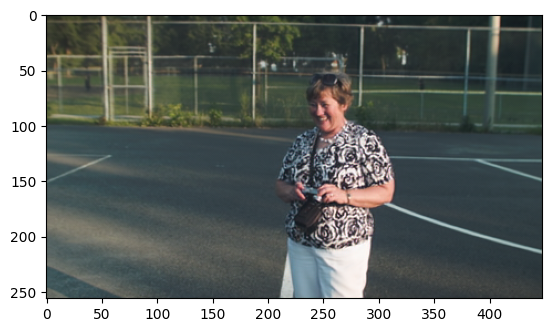

In [ ]:
prep = im_val.unsqueeze(0).to(device)
imshow(model(prep)[0].data.cpu())

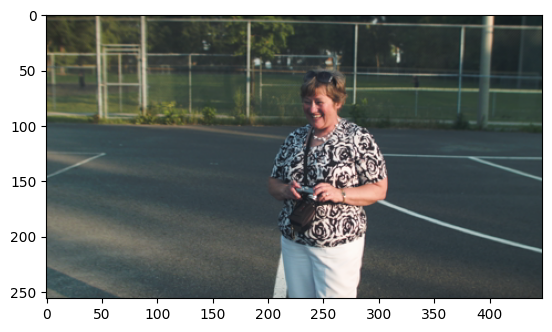

In [ ]:
imshow(l.data.cpu())

In [ ]:
imshow(prep.data.cpu())

ValueError: axes don't match array

In [ ]:
f = open("info_norm.txt", "r")

In [ ]:
data = f.read()
loss_vis = data.split(",")

In [ ]:
mass =[]
for i in loss_vis:
  mass.append(float(i[:9]))


In [ ]:
plt.scatter([i for i in range(len(mass))], mass)
plt.grid('major')